<a href="https://colab.research.google.com/github/PioDru/FlaskProject/blob/master/chest_xray_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

#print("Path to dataset files:", path)

In [15]:
#!/bin/bash
!curl -L -o ./chest-xray-pneumonia.zip https://www.kaggle.com/api/v1/datasets/download/paultimothymooney/chest-xray-pneumonia

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2349M  100 2349M    0     0  84.5M      0  0:00:27  0:00:27 --:--:--  129M


In [16]:
!unzip -q ./chest-xray-pneumonia.zip  -d chest-xray-pneumonia

replace chest-xray-pneumonia/chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Ustawienia ścieżek do danych – upewnij się, że struktura katalogów jest następująca:
# dataset/
# ├── train/
# │   ├── NORMAL/
# │   └── PNEUMONIA/
# ├── validation/
# │   ├── NORMAL/
# │   └── PNEUMONIA/
# └── test/
#     ├── NORMAL/
#     └── PNEUMONIA/
base_dir = '/content/chest-xray-pneumonia/chest_xray'  # np. './chest_xray'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Parametry przetwarzania obrazów
img_width, img_height = 150, 150  # rozmiar wejściowy obrazu
batch_size = 32

# Przygotowanie generatorów danych z augmentacją dla treningu
train_datagen = ImageDataGenerator(
    rescale=1./255,          # normalizacja pikseli
    rotation_range=20,       # losowe obroty
    width_shift_range=0.2,   # przesunięcia w poziomie
    height_shift_range=0.2,  # przesunięcia w pionie
    shear_range=0.2,         # transformacja skośna
    zoom_range=0.2,          # powiększenia
    horizontal_flip=True,    # odbicie lustrzane
    vertical_flip=True,
    fill_mode='nearest'
)

# Dla zbiorów walidacyjnego i testowego używamy tylko skalowania
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generatory danych
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle = True,               # True - zdjęcia będą losowo mieszane w całym zbiorze
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle = False,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle = False,
    class_mode='binary'
)

# Budowa modelu CNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')  # klasyfikacja binarna
])

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=4,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the best model weights
)

model_checkpoint = ModelCheckpoint(
    filepath='pneumonia_classification_model.keras',  # Use .keras extension
    monitor='val_accuracy',       # Metric to monitor
    save_best_only=True,          # Save only the best model
    mode='max'                    # Maximize the monitored metric
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.1,          # Reduce learning rate by a factor of 0.1
    patience=3           # Number of epochs to wait before reducing LR
)

# Kompilacja modelu
model.compile(
    loss='binary_crossentropy',
    #optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Wyświetlenie podsumowania modelu
model.summary()

# Trening modelu
epochs = 30 #20
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]  # Add callbacks here
)

# Ewaluacja na zbiorze testowym
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Dokładność na zbiorze testowym:', test_accuracy)

# Zapisanie modelu do pliku
model.save('pneumonia_classification_model.keras')
pretrained_model = tf.keras.applications.MobileNet()
tf.saved_model.save(pretrained_model, 'pneumonia_classification_model/mobilenet/1/')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       6,423,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,927,041 (26.42 MB)

 Trainable params: 6,927,041 (26.42 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 407ms/step - accuracy: 0.7429 - loss: 0.5842 - val_accuracy: 0.6250 - val_loss: 0.6973 - learning_rate: 1.0000e-04
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 421ms/step - accuracy: 0.8025 - loss: 0.4249 - val_accuracy: 0.6250 - val_loss: 0.7555 - learning_rate: 1.0000e-04
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 409ms/step - accuracy: 0.8590 - loss: 0.3112 - val_accuracy: 0.6250 - val_loss: 0.6999 - learning_rate: 1.0000e-04
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 417ms/step - accuracy: 0.8746 - loss: 0.2904 - val_accuracy: 0.8125 - val_loss: 0.4905 - learning_rate: 1.0000e-04
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 409ms/step - accuracy: 0.8913 - loss: 0.2671 - val_accuracy: 0.7500 - val_loss: 0.4259 - learning_rate: 1.0000e-04
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 403ms/step - accuracy: 0.8893 - loss: 0.2538 - val_accuracy: 0.6250 - val_loss: 0.9281 - learning_rate: 1.0000e-04
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 41

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[0.77734447]]
0.77734447
Predykcja (prawdopodobieństwo Pneumonii): 0.77734447
Wynik: Pneumonia


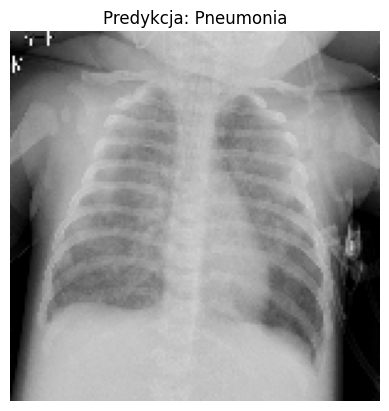

In [18]:
import keras
from keras import ops
from keras import utils
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Ścieżka do wybranego obrazu z zestawu danych
sample_image_path = '/content/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg'

# Wczytanie obrazu i przeskalowanie do wymiarów modelu
sample_img = keras.utils.load_img(sample_image_path, target_size=(img_width, img_height))
sample_img_array = keras.utils.img_to_array(sample_img)
sample_img_array = np.expand_dims(sample_img_array, axis=0)
sample_img_array /= 255.0

# Predykcja dla wybranego obrazu
prediction = model.predict(sample_img_array)[0][0]
print( model.predict(sample_img_array))
print(prediction)
print("Predykcja (prawdopodobieństwo Pneumonii):", prediction)
if prediction > 0.5:
    print("Wynik: Pneumonia")
else:
    print("Wynik: Normal")

# Wyświetlenie obrazu wraz z wynikową predykcją
plt.imshow(sample_img)
plt.title("Predykcja: " + ("Pneumonia" if prediction > 0.5 else "Normal"))
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[0.36200497]]
0.36200497
Predykcja (prawdopodobieństwo Pneumonii): 0.36200497
Wynik: Normal


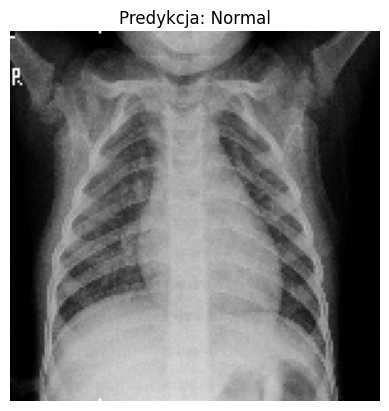

In [19]:
import keras
from keras import ops
from keras import utils
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


# Ścieżka do wybranego obrazu z zestawu danych
sample_image_path = '/content/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg'

# Wczytanie obrazu i przeskalowanie do wymiarów modelu
sample_img = keras.utils.load_img(sample_image_path, target_size=(img_width, img_height))
sample_img_array = keras.utils.img_to_array(sample_img)
sample_img_array = np.expand_dims(sample_img_array, axis=0)
sample_img_array /= 255.0

# Predykcja dla wybranego obrazu
prediction = model.predict(sample_img_array)[0][0]
print( model.predict(sample_img_array))
print(prediction)
print("Predykcja (prawdopodobieństwo Pneumonii):", prediction)
if prediction > 0.5:
    print("Wynik: Pneumonia")
else:
    print("Wynik: Normal")

# Wyświetlenie obrazu wraz z wynikową predykcją
plt.imshow(sample_img)
plt.title("Predykcja: " + ("Pneumonia" if prediction > 0.5 else "Normal"))
plt.axis('off')
plt.show()

In [20]:
!zip -q -r 'pneumonia_classification_model.zip' 'pneumonia_classification_model'

In [21]:
import tempfile

MODEL_DIR = '/content/model/'#tempfile.gettempdir()
MODEL_NAME = 'pneumonia_classification_model'
version = 1
export_path = os.path.join(MODEL_DIR, MODEL_NAME, str(version))
print('export_path = {}\n'.format(export_path))

# Use tf.saved_model.save to export a SavedModel
tf.saved_model.save(
    model,
    export_path
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /content/model/pneumonia_classification_model/1


Saved model:
total 176
drwxr-xr-x 2 root root   4096 Feb 18 21:02 assets
-rw-r--r-- 1 root root     56 Feb 18 21:28 fingerprint.pb
-rw-r--r-- 1 root root 167093 Feb 18 21:28 saved_model.pb
drwxr-xr-x 2 root root   4096 Feb 18 21:28 variables


In [22]:
import base64

# Ścieżka do wybranego obrazu z zestawu danych
sample_image_path = '/content/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg'  # zamień na faktyczną ścieżkę

# Wczytanie obrazu i przeskalowanie do wymiarów modelu
sample_img = keras.utils.load_img(sample_image_path, target_size=(img_width, img_height))

with open(sample_image_path, "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read())

print(encoded_string)

b'/9j/4RD6RXhpZgAATU0AKgAAAAgADAEAAAMAAAABBQgAAAEBAAMAAAABA6AAAAECAAMAAAAEAAAAngEGAAMAAAABAAEAAAESAAMAAAABAAEAAAEVAAMAAAABAAQAAAEaAAUAAAABAAAApgEbAAUAAAABAAAArgEoAAMAAAABAAIAAAExAAIAAAAgAAAAtgEyAAIAAAAUAAAA1odpAAQAAAABAAAA7AAAASQACAAIAAgACAAK/IAAACcQAAr8gAAAJxBBZG9iZSBQaG90b3Nob3AgQ1M2IChNYWNpbnRvc2gpADIwMTg6MDE6MDQgMTM6Mjk6MTUAAAAABJAAAAcAAAAEMDIyMaABAAMAAAAB//8AAKACAAQAAAABAAAFCKADAAQAAAABAAADoAAAAAAAAAAGAQMAAwAAAAEABgAAARoABQAAAAEAAAFyARsABQAAAAEAAAF6ASgAAwAAAAEAAgAAAgEABAAAAAEAAAGCAgIABAAAAAEAAA9wAAAAAAAAAEgAAAABAAAASAAAAAH/2P/tAAxBZG9iZV9DTQAB/+4ADkFkb2JlAGSAAAAAAf/bAIQADAgICAkIDAkJDBELCgsRFQ8MDA8VGBMTFRMTGBEMDAwMDAwRDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAENCwsNDg0QDg4QFA4ODhQUDg4ODhQRDAwMDAwREQwMDAwMDBEMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwM/8AAEQgAcwCgAwEiAAIRAQMRAf/dAAQACv/EAT8AAAEFAQEBAQEBAAAAAAAAAAMAAQIEBQYHCAkKCwEAAQUBAQEBAQEAAAAAAAAAAQACAwQFBgcICQoLEAABBAEDAgQCBQcGCAUDDDMBAAIRAwQhEjEFQVFhEyJxgTIGFJGhsUIjJBVSwWIzNHKC0UMHJZJT8OHxY3M1FqKygyZEk1RkRcKjdDYX0lXiZfKzhMPTdePzRieUpIW0lc